In [83]:
import urllib,os
from netCDF4 import Dataset

download=False
the_file='case_60_10.nc'
the_url="http://clouds.eos.ubc.ca/~phil/docs/atsc500/data/{}".format(the_file)
if download:
    out=urllib.request.urlretrieve(the_url,the_file)
    print(out)
print("download {}: size is {:8.4g} Mbytes".format(the_file,os.path.getsize(the_file)*1.e-6))

download case_60_10.nc: size is    499.3 Mbytes


In [84]:
!ncdump -h case_60_10.nc

netcdf case_60_10 {
dimensions:
	time = 48 ;
	x = 25 ;
	y = 20 ;
	z = 130 ;
variables:
	float time(time) ;
		string time:units = "minutes" ;
	float x(x) ;
		string x:units = "meters" ;
	float y(y) ;
		string y:units = "meters" ;
	float z(z) ;
		string z:units = "meters" ;
	float press(z) ;
		string press:units = "Pa" ;

// global attributes:
		:heat_flux_W_m2 = 100L ;
		:gamma_K_km = 10L ;

group: c1 {
  variables:
  	float TABS(time, z, y, x) ;
  		string TABS:units = "K" ;
  	float W(time, z, y, x) ;
  		string W:units = "m/s" ;
  	float U(time, z, y, x) ;
  		string U:units = "m/s" ;
  	float V(time, z, y, x) ;
  		string V:units = "m/s" ;
  } // group c1

group: c2 {
  variables:
  	float TABS(time, z, y, x) ;
  		string TABS:units = "K" ;
  	float W(time, z, y, x) ;
  		string W:units = "m/s" ;
  	float U(time, z, y, x) ;
  		string U:units = "m/s" ;
  	float V(time, z, y, x) ;
  		string V:units = "m/s" ;
  } // group c2

group: c3 {
  variables:
  	float TABS(time, z, y, x) ;
  

Netcdf file layout:  10 groups corresponding to 10 different ensemble members.  Small slice of larger domain of LES run with surface heat flux of 60 W/m^2 and stable layer with dT/dz = 10 K/km.  Snapshots every 10 minutes for 8 hours.

[ 100.  225.  275.  325.  375.  450.  475.  490.  535.  575.  530.  650.
  660.  650.  665.  705.]


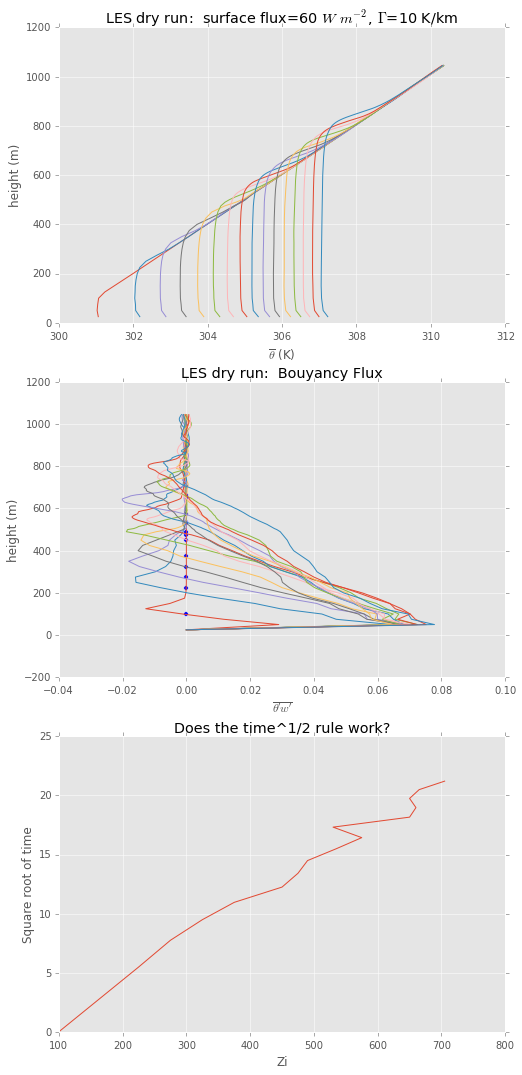

In [85]:
from matplotlib import pyplot as plt
import numpy as np
% matplotlib inline
def make_theta(temp_m,press,W_pert,temp):
    """
      temp in K
      press in Pa
      returns theta in K
    """
    p0=1.e5
    Rd=287.
    cpd=1004.
    term1=(p0/press)**(Rd/cpd)
   # term1=term1[np.newaxis,:]
    term1=term1[np.newaxis,:,np.newaxis,np.newaxis]
    theta = temp*term1
    theta_m=theta.mean(axis=3).mean(axis=2)
    theta_pert=theta-theta_m[:,:,np.newaxis,np.newaxis]
    W_m = W.mean(axis=3).mean(axis=2)
    W_pert = W - W_m[:,:,np.newaxis,np.newaxis]
    Bf = theta_pert*W_pert
    Bf=Bf.mean(axis=3).mean(axis=2)
    theta=theta.mean(axis=3).mean(axis=2)
    return (theta,Bf)

    
case_name='case_60_10.nc'
for grp in range (1,11):
    ensemble='c' + str(grp)

    with Dataset(case_name,'r') as ncin:
        group = ncin.groups[ensemble]
        temp=group.variables['TABS'][...]
        W=group.variables['W'][...]
        press=ncin.variables['press'][...]
        z=ncin.variables['z'][...]
    theta,Bf = make_theta(temp_m,press,W,temp)
    if ensemble == 'c1':
        theta_av = theta
        Bf_av = Bf
    else:
        theta_av=theta_av+theta
        Bf_av=Bf_av+Bf
theta_av =theta_av/10
Bf_av=Bf_av/10
ct = 0
zi = np.zeros(temp.shape[0]/3)
Time = np.zeros(temp.shape[0]/3)
plt.style.use('ggplot')
fig,ax=plt.subplots(3,1,figsize=(8,18))
for i in np.arange(0,temp.shape[0],3):
    Time[ct] = ct*30
    ax[0].plot(theta_av[i,:],z)
    ax[1].plot(Bf_av[i,:],z)
    minn = np.argmin(Bf_av[i,:])
    x = np.where(Bf_av[i,:]<0)
    zi[ct] = x[0][0]
    zi[ct] = z[zi[ct]]
    ax[1].scatter(0,zi[ct])
    ct += 1
ax[2].plot(zi,Time**.5)

out=ax[2].set(xlabel=r"Zi",ylabel='Square root of time',
           title='Does the time^1/2 rule work?')

out=ax[1].set(xlabel=r"$\overline{\theta'w'}$",ylabel='height (m)',
           title='LES dry run:  Bouyancy Flux')

out=ax[0].set(xlabel=r'$\overline{\theta}$ (K)',ylabel='height (m)',
           title='LES dry run:  surface flux=60 $W\,m^{-2}$, $\Gamma$=10 K/km')

print (zi)


[ 0.89558713  0.09662496  0.14712526  0.23839867  0.7657402  -0.03224326
 -0.20811146  0.43582567  0.41080999 -1.52615725  2.37170196 -0.23822066
 -0.75686275 -0.11616219  0.56547471]


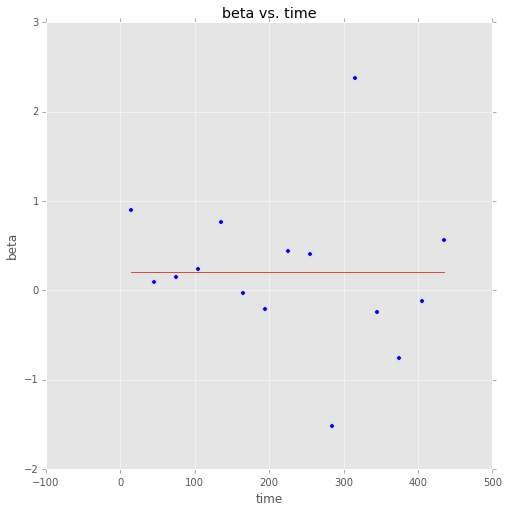

In [113]:
Beta = np.zeros(shape = ((zi.shape[0])-1,2))
time = np.zeros(shape = (zi.shape[0])-1)
for i in range (0,zi.shape[0]-1):
    DhDt = (zi[i+1]-zi[i])/(Time[i+1]-Time[i])/60 ### put into m/s
    time[i] = (Time[i+1]+Time[i])/2
    h = (zi[i+1]+zi[i])/2
    Bf = (Bf_av[i+1,1]+Bf_av[i,1])/2
    gamma = 0.01                 ## Gamma = 10 k/km = .01 k/m
    beta = (DhDt*h*gamma/Bf)/2-1/2
    Beta[i,0] = beta
    Beta[i,1] = .2
print (Beta[:,0])
fig,ax=plt.subplots(1,1,figsize=(8,8))
ax.plot(time,Beta[:,1])
ax.scatter(time,Beta[:,0])
out=ax.set(xlabel='time',ylabel='beta',
           title='beta vs. time')

#  Some of the values are ~ 0.2, but there is a good bit of scatter.
    ### Maybe its because I'm using delta h / detla t rather than the actual derivative?